In [102]:
from fmp_data import Dataset, AFTER_PRICE, FMPPriceLoader
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [103]:
stocks = fmp('SELECT * from stock22to24')
symbols = stocks.symbol.unique()
pl = FMPPriceLoader()

d = Dataset(symbols,{
    AFTER_PRICE: '',
    'revenue': '',
    'free_cash_flow_per_share': 'fcf_per_share',
    'operating_profit_margin': 'opm',
    }).data

d = d.merge(stocks, on='symbol', how='inner')
d['quarter'] = pd.to_datetime(d['date']).dt.strftime('%Y-%m')

In [53]:
d.head()

,date,symbol,revenue,fcf_per_share,opm,after_price,sector,industry,market_cap,quarter
0,1999-01-31,A,1.786000e+09,NaN,1.000000,25.80,Healthcare,Diagnostics & Research,33854.6,1999-01
1,1999-04-30,A,2.010000e+09,NaN,1.000000,25.80,Healthcare,Diagnostics & Research,33854.6,1999-04
2,1999-07-31,A,2.087000e+09,NaN,1.000000,25.80,Healthcare,Diagnostics & Research,33854.6,1999-07
3,1999-10-31,A,2.448000e+09,NaN,-2.100490,25.80,Healthcare,Diagnostics & Research,33854.6,1999-10
4,2000-01-31,A,2.246000e+09,0.667426,0.076135,39.94,Healthcare,Diagnostics & Research,33854.6,2000-01


In [54]:
tech = d[d.sector == 'Technology']

In [61]:
t = d

pl = FMPPriceLoader()
price_rec = []
for date, symbol in t[['date', 'symbol']].values:
    one_quarter_later = pd.to_datetime(date) + pd.Timedelta(days=28 * 3)
    if one_quarter_later <= pd.to_datetime('2024-11-01'):
        try:
            price, _ = pl.get_last_available_price(symbol, one_quarter_later)
        except KeyError:
            print('Failed to get price for {} on {}'.format(symbol, one_quarter_later))
        else:
            price_rec.append({'date': date,'symbol': symbol, 'one_quarter_later': price})
prices = pd.DataFrame.from_records(price_rec)
data = t.merge(prices, how='left', on=['date', 'symbol'])
data = data[~data.one_quarter_later.isnull()].copy()
data['fcf_to_price'] = data['fcf_per_share'] / data['after_price']
data['d90'] = data.groupby('symbol')['after_price'].pct_change()
data['d180'] = data.groupby('symbol')['after_price'].pct_change(periods=2)
data['d270'] = data.groupby('symbol')['after_price'].pct_change(periods=3)
data['d360'] = data.groupby('symbol')['after_price'].pct_change(periods=4)
data['revenue_yoy'] = data.groupby('symbol')['revenue'].pct_change(periods=4)
data['price1q'] = data['one_quarter_later'] / data['after_price'] - 1
data = data.dropna()     

gp = data.groupby(['quarter', 'sector'])

rank_cols = ['fcf_to_price', 'opm', 'd90', 'd180', 'd270', 'd360', 'revenue_yoy']
ranks_df = pd.DataFrame()
for col in rank_cols:
    # Rank the column within each sector
    ranks = data.groupby('sector')[col].rank(method='dense', ascending=False)
    
    # Normalize the ranks to percentiles
    ranks_percentile = ranks / ranks.groupby(data['sector']).transform('count')
    
    # Store the percentile column in the new DataFrame
    ranks_df[f'{col}_q'] = ranks_percentile
data = pd.concat([data, ranks_df], axis=1)
data = data[['symbol', 'quarter', 'sector', 'fcf_to_price_q', 'opm_q', 'd90_q', 'd180_q', 'd270_q', 'd360_q', 'revenue_yoy_q', 'price1q']]

Failed to get price for A on 1999-04-25 00:00:00
Failed to get price for A on 1999-07-23 00:00:00
Failed to get price for A on 1999-10-23 00:00:00
Failed to get price for AAL on 1995-03-25 00:00:00
Failed to get price for AAL on 1995-06-23 00:00:00
Failed to get price for AAL on 1995-09-22 00:00:00
Failed to get price for AAL on 1995-12-23 00:00:00
Failed to get price for AAL on 1996-03-24 00:00:00
Failed to get price for AAL on 1996-06-23 00:00:00
Failed to get price for AAL on 1996-09-22 00:00:00
Failed to get price for AAL on 1996-12-23 00:00:00
Failed to get price for AAL on 1997-03-25 00:00:00
Failed to get price for AAL on 1997-06-23 00:00:00
Failed to get price for AAL on 1997-09-22 00:00:00
Failed to get price for AAL on 1997-12-23 00:00:00
Failed to get price for AAL on 1998-03-25 00:00:00
Failed to get price for AAL on 1998-06-23 00:00:00
Failed to get price for AAL on 1998-09-22 00:00:00
Failed to get price for AAL on 1998-12-23 00:00:00
Failed to get price for AAL on 1999-0

/var/folders/jv/zpk9r3mn7dq5ghtk8zl52vt00000gn/T/ipykernel_7431/1998375014.py:22: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['revenue_yoy'] = data.groupby('symbol')['revenue'].pct_change(periods=4)


In [69]:
data = data[['symbol', 'quarter', 'fcf_to_price_q', 'opm_q', 'd90_q', 'd180_q', 'd270_q', 'd360_q', 'revenue_yoy_q', 'price1q']]

In [85]:
print(data.head().to_csv(None, sep='\t'))

	symbol	quarter	fcf_to_price_q	opm_q	d90_q	d180_q	d270_q	d360_q	revenue_yoy_q	price1q
7	A	2000-10	0.453928542228763	0.28926498242171533	0.27148229907611804	0.9258032867304391	0.806516229253536	0.482012917995258	0.20006540757092633	0.35491949910554554
8	A	2001-01	0.7726678112991578	0.36938925680647533	0.21588586378873353	0.17226718992723408	0.8730684326710817	0.7092224675006132	0.25917749979560134	-0.28827460510328073
9	A	2001-04	0.6882511650723572	0.5838852097130243	0.8711062055432917	0.7257787588913417	0.5935328264246587	0.912844411740659	0.7557436023219688	-0.28971962616822433
10	A	2001-07	0.44845065816368246	0.6479437494890034	0.8599051590221568	0.9157468727005151	0.8525059275611152	0.7855040470934511	0.8698389338565939	-0.1662804171494786
11	A	2001-10	0.01181424249856921	0.6918485814733055	0.8260976207996076	0.9000081759463658	0.9282969503720055	0.8875807374703621	0.8954296459815224	0.25744047619047605



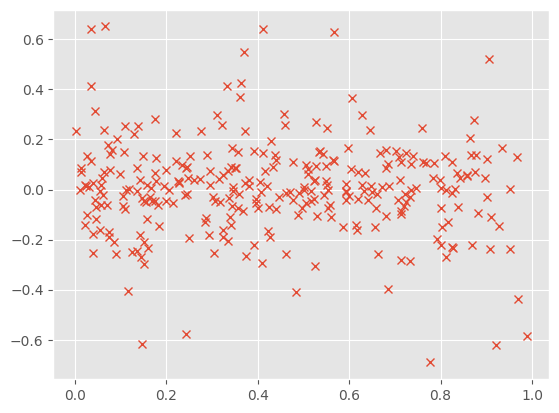

In [77]:

t = data[(data.price1q < 1) ]

if len(t) >= 300:
    t = t.sample(300)
x = t.opm_q
y = t.price1q

plt.plot(x, y, 'x')

In [100]:
data = data.replace([np.inf, -np.inf], np.nan).dropna()
d = d[data.sector == 'Technology']
X = d[['fcf_to_price_q', 'opm_q', 'd90_q', 'd180_q', 'd270_q', 'd360_q', 'revenue_yoy_q']]
y = d['price1q']

AttributeError: 'DataFrame' object has no attribute 'sector'

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

R-squared: 6.986708644396433e-05
Mean Squared Error: 26.458605878637933
Mean Absolute Error: 0.18007246518440204


In [101]:
data.head()

,symbol,quarter,fcf_to_price_q,opm_q,d90_q,d180_q,d270_q,d360_q,revenue_yoy_q,price1q
7,A,2000-10,0.453929,0.289265,0.271482,0.925803,0.806516,0.482013,0.200065,0.354919
8,A,2001-01,0.772668,0.369389,0.215886,0.172267,0.873068,0.709222,0.259177,-0.288275
9,A,2001-04,0.688251,0.583885,0.871106,0.725779,0.593533,0.912844,0.755744,-0.289720
10,A,2001-07,0.448451,0.647944,0.859905,0.915747,0.852506,0.785504,0.869839,-0.166280
11,A,2001-10,0.011814,0.691849,0.826098,0.900008,0.928297,0.887581,0.895430,0.257440
